## Import packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.manifold import TSNE
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import load_model
from preprocess import water_postprocess
from scipy import stats
from scipy.stats import mannwhitneyu, wilcoxon, ttest_rel
from performance import metrics_s1_t1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

## Preprocess data

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.7
split_2 = 0.85

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = water_postprocess(n_hours, k, masked_value, split_1, split_2)

Index(['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2',
       'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26', 'HWS_S25A',
       'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'],
      dtype='object')


In [6]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(67435, 96, 16) (14451, 96, 16) (14451, 96, 16) (67435, 96) (14451, 96) (14451, 96)


### Rain threshold

In [7]:
# train_X_mask_rain_acc = np.sum(train_X_mask[:, -24:, 0], axis=1)
# print(train_X_mask_rain_acc.shape)

# test_X_mask_rain_acc = np.sum(test_X_mask[:, -24:, 0], axis=1)
# print(test_X_mask_rain_acc.shape)

train_X_mask_rain_acc = train_X_mask[:, 0, 0]
print(train_X_mask_rain_acc.shape)

val_X_mask_rain_acc = val_X_mask[:, 0, 0]
print(val_X_mask_rain_acc.shape)

test_X_mask_rain_acc = test_X_mask[:, 0, 0]
print(test_X_mask_rain_acc.shape)

(67435,)
(14451,)
(14451,)


In [8]:
percentile = 95

merged_array = np.concatenate((train_X_mask_rain_acc, val_X_mask_rain_acc, test_X_mask_rain_acc))

percentile_rain = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_rain)

95th Percentile of Daily Rain: 0.010711610503493287


### train_X_mask_filter

In [9]:
train_X_mask_extreme = train_X_mask[train_X_mask_rain_acc > percentile_rain]
print(train_X_mask_extreme.shape)

train_ws_y_extreme = train_ws_y[train_X_mask_rain_acc > percentile_rain]
print(train_ws_y_extreme.shape)

(3251, 96, 16)
(3251, 96)


In [10]:
train_X_mask_normal = train_X_mask[train_X_mask_rain_acc <= percentile_rain]
print(train_X_mask_normal.shape)

train_ws_y_normal = train_ws_y[train_X_mask_rain_acc <= percentile_rain]
print(train_ws_y_normal.shape)

(64184, 96, 16)
(64184, 96)


### val_X_mask_filter

In [11]:
val_X_mask_extreme = val_X_mask[val_X_mask_rain_acc > percentile_rain]
print(val_X_mask_extreme.shape)

val_ws_y_extreme = val_ws_y[val_X_mask_rain_acc > percentile_rain]
print(val_ws_y_extreme.shape)

(536, 96, 16)
(536, 96)


In [12]:
val_X_mask_normal = val_X_mask[val_X_mask_rain_acc <= percentile_rain]
print(val_X_mask_normal.shape)

val_ws_y_normal = val_ws_y[val_X_mask_rain_acc <= percentile_rain]
print(val_ws_y_normal.shape)

(13915, 96, 16)
(13915, 96)


### test_X_mask_filter

In [13]:
test_X_mask_extreme = test_X_mask[test_X_mask_rain_acc > percentile_rain]
print(test_X_mask_extreme.shape)

test_ws_y_extreme = test_ws_y[test_X_mask_rain_acc > percentile_rain]
print(test_ws_y_extreme.shape)

(1030, 96, 16)
(1030, 96)


In [14]:
test_X_mask_normal = test_X_mask[test_X_mask_rain_acc <= percentile_rain]
print(test_X_mask_normal.shape)

test_ws_y_normal = test_ws_y[test_X_mask_rain_acc <= percentile_rain]
print(test_ws_y_normal.shape)

(13421, 96, 16)
(13421, 96)


## Test model

In [15]:
# ws_threshold = 2.58
time_index = 0

#### Extreme

In [256]:
saved_model = load_model('../saved_models_mlp/water_N_95.h5') 
# saved_model = load_model('../saved_models_mlp/water_E_95.h5') 


# saved_model = load_model('../saved_models_mlp/water_all_95.h5') 
# saved_model = load_model('../saved_models_mlp/water_all_95_ft.h5')

# saved_model = load_model('../saved_models_mlp/water_all_weighted_IPF_95.h5')
# saved_model = load_model('../saved_models_mlp/water_all_weighted_IPF_95_ft.h5')

# saved_model = load_model('../saved_models_mlp/water_all_weighted_EVT_95.h5')
# saved_model = load_model('../saved_models_mlp/water_all_weighted_EVT_95_ft.h5')

# saved_model = load_model('../saved_models_mlp/water_all_weighted_META_95.h5')
# saved_model = load_model('../saved_models_mlp/water_all_weighted_META_95_ft.h5')

yhat_extreme = saved_model.predict(test_X_mask_extreme)
inv_yhat_extreme = ws_scaler.inverse_transform(yhat_extreme)
inv_y_extreme = ws_scaler.inverse_transform(test_ws_y_extreme)
test_errors_extreme = inv_yhat_extreme - inv_y_extreme

metrics_s1_t1(inv_y_extreme.min(), time_index, inv_y_extreme, inv_yhat_extreme, test_errors_extreme)

Peformance when water level is over -0.8199999928474426 ft 

------ MAE & RMSE ------
MAE = 0.191218
RMSE = 0.259336 

------ Max Errors (t+1 at S1) ------
Max Error of Over Estimation: 0.7057215
Max Error of Under Estimation: -0.66416955
Max Abs Error of Under Estimation: 0.7057215 

------ Time # (t+1 at S1) ------
Time# of Over Estimation: 712
Time# of Under Estimation: 318 

------ Area (t+1 at S1) ------
Area of Over Estimation: 134.725479722023
Area of Under Estimation: -47.07193026505411


In [263]:
import tensorflow as tf
import numpy as np

def my_integrated_gradients(model, input_data_list, baseline_data_list, num_steps=50):
    # Convert input and baseline data to tensors
    input_tensors = [tf.convert_to_tensor(data, dtype=tf.float32) for data in input_data_list]
    baseline_tensors = [tf.convert_to_tensor(data, dtype=tf.float32) for data in baseline_data_list]
    
    # Convert input and baseline tensors to NumPy arrays
    input_tensors = np.array(input_tensors)
    baseline_tensors = np.array(baseline_tensors)
    
    # Calculate the difference between input and baseline
    input_diff = input_tensors - baseline_tensors

    # Initialize an array to store the integrated gradients
    integrated_gradients = np.zeros_like(input_tensors)
    
    # Compute integrated gradients for each step
    for step in range(num_steps):
        # Interpolate between baseline and input
        interpolated_input = baseline_tensors + (input_diff * step / num_steps)
        
        # Convert interpolated_input to TensorFlow tensor
        interpolated_input = tf.convert_to_tensor(interpolated_input, dtype=tf.float32)
        
        # Compute gradients at the interpolated input
        with tf.GradientTape() as tape:
            tape.watch(interpolated_input)
            interpolated_predictions = model(interpolated_input)
            
        interpolated_gradients = tape.gradient(interpolated_predictions, interpolated_input)
        
        # Accumulate the gradients to compute integrated gradients
        integrated_gradients += interpolated_gradients / num_steps
    
    # Average the accumulated gradients and multiply by input difference
    integrated_gradients *= input_diff / num_steps

    # Return the computed integrated gradients
    return integrated_gradients


In [264]:
test_X_mask_extreme.shape

(1030, 96, 16)

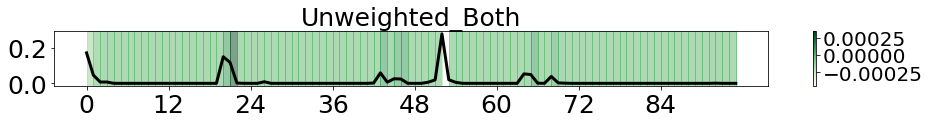

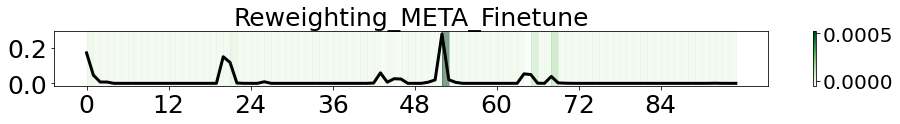

In [296]:
demo = 160  # 470

input_data = test_X_mask_extreme[demo:demo+1, :, :]
baseline_data = np.zeros((1, 96, 16), dtype=np.float32) 

# paths = ['water_N_95.h5', 'water_E_95.h5', 'water_all_95.h5', 'water_all_weighted_META_95_ft.h5']
paths = ['water_all_95.h5', 'water_all_weighted_META_95_ft.h5']
models = ['Unweighted_Both', 'Reweighting_META_Finetune']

for i in range(len(paths)):
    saved_model = load_model('../saved_models_mlp/' + paths[i]) 

    # Compute integrated gradients
    attributions = my_integrated_gradients(saved_model, input_data, baseline_data)

    attributions_array = attributions.numpy()
    attributions_matrix = attributions_array.reshape((96, 16))
    
    
    # Create a DataFrame for easier handling
    df = pd.DataFrame({'TimeSeries': input_data[0, :, 0], 'Contributions': attributions_matrix[:, 0]})

    # Normalize the contributions to its range for color mapping
    norm = Normalize(vmin=df['Contributions'].min(), vmax=df['Contributions'].max())

    # Create a colormap
    cmap = plt.get_cmap('Greens') # 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greens'

    fig, ax = plt.subplots(figsize=(16, 1))

    # Time series line plot
    ax.plot(df.index, df['TimeSeries'], color='black', lw=3)

    # Create a heatmap effect by coloring the background according to the contribution values
    for idx in range(len(df['Contributions'])):
        plt.axvspan(df.index[idx], 
                    df.index[idx+1] if idx+1 < len(df.index) else df.index[idx], 
                    color=cmap(norm(df['Contributions'].iloc[idx])), 
                    alpha=0.5
                   )

    # Create a colorbar to show the mapping from contribution value to color
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)

    #cbar.set_label('Contribution', fontsize=16) 
    cbar.ax.tick_params(labelsize=20) 
    
    # Increase xticks fontsize and set custom tick locations and labels
    custom_xticks = [0, 12, 24, 36, 48, 60, 72, 84]
    plt.xticks(custom_xticks, custom_xticks)   # Set custom tick locations and labels, adjust fontsize as needed

    plt.xticks(fontsize=25)  
    plt.yticks(fontsize=25)
    plt.title('{}'.format(models[i]), fontsize=25)
    plt.show()
    plt.close()